In [11]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
import pyspark
pbar = ProgressBar()

- |#                                                  | 0 Elapsed Time: 0:00:00


In [12]:
# Check which device is being used
if torch.cuda.is_available():
    print("True")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

True


device(type='cuda')

In [7]:
IMAGE_FOLDER = Path('map-proj-v3_2/')
SAVE_FOLDER = Path('Preprocessed')

In [18]:
#Utilizing Spark for data ingestion.
import findspark
findspark.init()

# Initialize Spark session
spark = SparkSession.builder.appName("SVM").getOrCreate()

In [19]:
# Reading spark dataframe.
spark_df = spark.read.format("binaryFile").load('map-proj-v3_2/')

In [20]:
spark_df.count()

64947

In [23]:
#Utilizing UDF to preprocess images. 
from pyspark.sql.functions import udf
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType
import io

# Preprocessing UDF function, resizes images to 224x224 images and normalizes pixel values to between 0 and 1.
def preprocess_image(image_data):
    image = Image.open(io.BytesIO(image_data))
    resized_image = image.resize((224, 224))

    # Normalize pixel values to between 0 and 1
    normalized_image = np.array(resized_image) / 255.0
    flattened_image = normalized_image.flatten()

    return flattened_image.tobytes()

# Register the UDF
process_image_udf_test = udf(preprocess_image, BinaryType())

# Apply the UDF to the DataFrame
processed_df = spark_df.withColumn("reshaped_image", process_image_udf_test(spark_df["content"]))

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = processed_df.toPandas()

In [24]:
# Terminating spark session.

spark.stop()

In [13]:
# Ingesting the text file containing labels using pandas
lines = []
with open('labels-map-proj_v3_2_train_val_test.txt', 'r') as file:
    lines = file.readlines()
    splits = [i.split() for i in lines]

labels = pd.DataFrame(splits).rename(columns={0: 'File Name', 1: 'Label', 2: 'Train or Test'})
labels

,File Name,Label,Train or Test
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
2,ESP_013049_0950_RED-0067-brt.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train
...,...,...,...
67805,ESP_018707_2205_RED-0041.jpg,0,test
67806,ESP_018707_2205_RED-0062.jpg,0,test
67807,ESP_018707_2205_RED-0105.jpg,0,test
67808,ESP_018707_2205_RED-0058.jpg,0,test


In [14]:
labels['Label'].value_counts()

Label
0    52722
1     5857
6     2772
4     1654
3     1603
7     1568
2      857
5      777
Name: count, dtype: int64

In [15]:
# Mapping taken from the .csv provided in the dataset.
mapping_dict = {'0': 'Other', '1': 'Crater', '2': 'Dark Dune', '3':'Slope Streak', 
                '4':'Bright Dune', '5':'Impact Ejecta', '6':'Swiss Cheese', '7':'Spider'}

# Making new column containing the landmark's actual name.
labels['Landmark Name'] = labels['Label'].map(mapping_dict)
labels

,File Name,Label,Train or Test,Landmark Name
0,ESP_013049_0950_RED-0067.jpg,7,train,Spider
1,ESP_013049_0950_RED-0067-fv.jpg,7,train,Spider
2,ESP_013049_0950_RED-0067-brt.jpg,7,train,Spider
3,ESP_013049_0950_RED-0067-r90.jpg,7,train,Spider
4,ESP_013049_0950_RED-0067-r180.jpg,7,train,Spider
...,...,...,...,...
67805,ESP_018707_2205_RED-0041.jpg,0,test,Other
67806,ESP_018707_2205_RED-0062.jpg,0,test,Other
67807,ESP_018707_2205_RED-0105.jpg,0,test,Other
67808,ESP_018707_2205_RED-0058.jpg,0,test,Other


In [16]:
labels = labels.drop_duplicates()

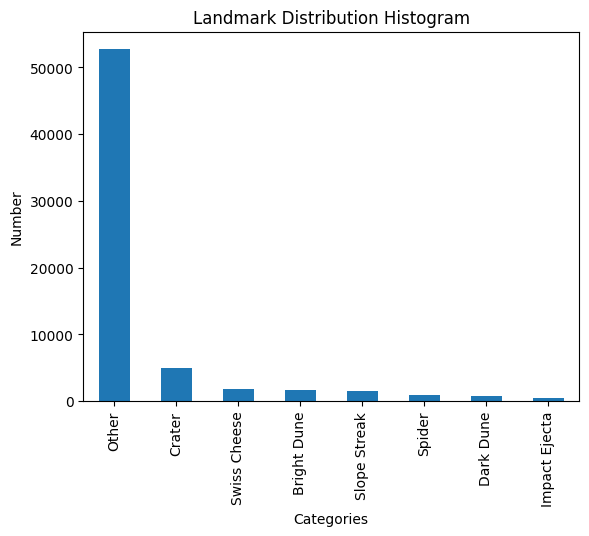

In [17]:
#Plot distribution of classes within dataset
fig, ax = plt.subplots()
labels['Landmark Name'].value_counts().plot(ax=ax, kind='bar')
plt.title('Landmark Distribution Histogram')
plt.xlabel('Categories')
plt.ylabel('Number')
plt.show()

In [8]:
# Sanity check that cv2 can read images.
img = cv2.imread('map-proj-v3_2\ESP_011677_1655_RED-0070-r90.jpg', -1)
img

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [116, 120, 122, ..., 126, 120, 123],
       [110, 115, 121, ..., 124, 119, 123],
       [118, 122, 127, ..., 130, 127, 132]], dtype=uint8)

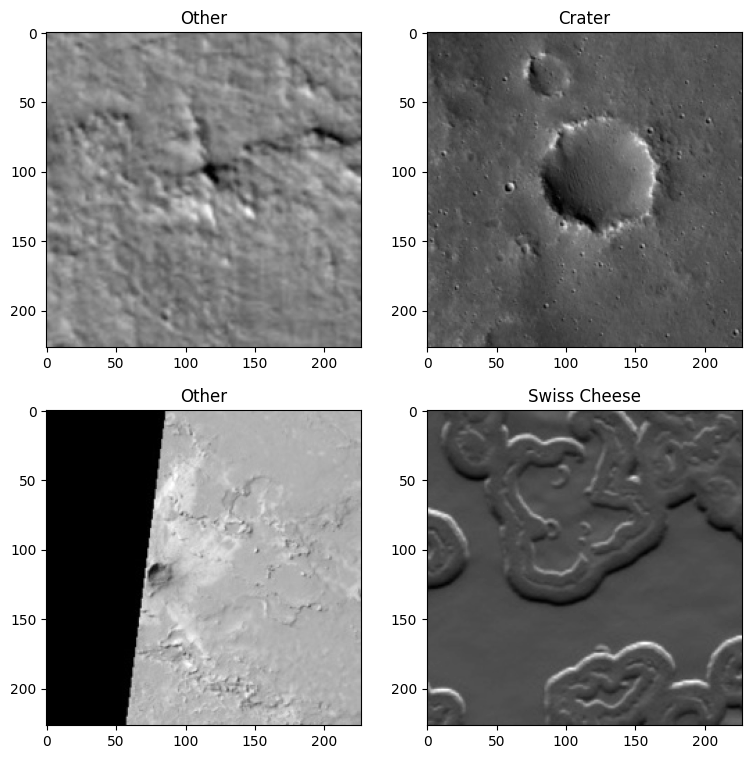

In [9]:
# Plotting sample images from the dataset.

fig, axis = plt.subplots(2, 2, figsize=(9, 9))
plot_df = labels.sample(n=4, random_state=42)
count = 0
for i in range(2):
    for j in range(2):
        #Get image path
        fname = plot_df['File Name'].iloc[count]
        fpath = IMAGE_FOLDER/fname
        #Get image into a pixel array
        img = cv2.imread(str(fpath), -1)

        axis[i][j].imshow(img, cmap='gray')
        axis[i][j].set_title(plot_df['Landmark Name'].iloc[count])
        count += 1

In [11]:
# Loop for saving the preprocessed images as numpy arrays.
# Do not run more than once unless you want more disk space used up
for idx, row in enumerate(pbar(pandas_df.iterrows())):
    fpath = IMAGE_FOLDER/row["path"]
    label = labels['Label'].iloc[idx]

    #Reshaping flattened numpy array from Spark dataframe.
    img = np.frombuffer(row["reshaped image"], dtype=np.float32)
    img = img.reshape((224, 224, 1)) 
    
    #Doing 75% train, 25% test. 48778 will be the train size.
    if idx < 48778:
        tt_split = 'train'
    else:
        tt_split = 'test'

    savepath = SAVE_FOLDER/tt_split/label
    np.save(savepath/fname, img)

100% (67810 of 67810) |##################| Elapsed Time: 0:07:16 Time:  0:07:16


In [8]:
# Set up datasets using datasetfolder
from torchvision.datasets import DatasetFolder

# Function to turn numpy arrays into Pytorch tensors
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Loader function for datasetfolder
def load_file(path):
     return np.load(path).astype(np.float32)

#Instantiate the folders
train_ds = DatasetFolder(root='Preprocessed/train', loader=load_file, extensions='npy', transform=data_transform)
test_ds = DatasetFolder(root='Preprocessed/test', loader=load_file, extensions='npy', transform=data_transform)


In [24]:
train_ds[0][0].shape

torch.Size([1, 224, 224])

In [26]:
len(test_ds)

16169

In [27]:
len(train_ds)

48778

In [39]:
# Sanity check of overall dataset.
len(test_ds) + len(train_ds)

64947

In [3]:
#Modified Alexnet
class AlexNet(nn.Module):
    def __init__(self, num_classes=8):
        super(AlexNet, self).__init__()
        self.features = models.alexnet().features
        # Changing input layer to accomodate greyscale image
        self.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [5]:
# Setting Hyperparameters
num_classes = 8
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)
#model._modules

In [10]:
torch.manual_seed(30)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 

# Set up Dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [95]:
import time
from sklearn.metrics import f1_score

start_time = time.time()

# Retain loss and metric info for further analysis
train_losses = []
test_losses = []
train_correct = []
test_correct = []
f1_best = 0
f1_scores = []

#Training loop
for i in range(num_epochs):
    model.train()
    trn_corr = 0
    tst_corr = 0
    
    # Running the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Keeping track of the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Backprop, optimize for the batch.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Printing out the interim results
        if b%batch_size == 0:
            print(f'Epoch: {i:2}  batch: {b:4} [{batch_size*b:6}/48778]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(batch_size*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Testing, save if the weighted f1 score is better
    model.eval()
    all_preds = []
    all_labels = []

    #Testing loop, run every epoch
    with torch.no_grad():
        for X_test, y_test in test_loader:
            #Load to gpu
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            #run model on test dataset
            outputs = model(X_test)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())
            
            # Keeping track of the number of correct predictions
            tst_corr += (preds == y_test).sum()
            
    loss = criterion(outputs, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

    #Save f1 score, save model if best model
    f1_curr = f1_score(all_labels, all_preds, average='weighted')
    f1_scores.append(f1_curr)
    if f1_curr > f1_best:
        f1_best = f1_curr
        torch.save(model.state_dict(), 'hirise-alexnet-best.pt')

# Printing out training time in seconds
print(f'\nTraining Time: {time.time() - start_time:.0f} seconds')

# Printing out training time in minutes
total_time = time.time() - start_time
print(f'\nTraining Time: {total_time/60} minutes')

Epoch:  0  batch:   64 [  4096/48778]  loss: 0.59968835  accuracy:  79.858%
Epoch:  0  batch:  128 [  8192/48778]  loss: 0.80593151  accuracy:  80.664%
Epoch:  0  batch:  192 [ 12288/48778]  loss: 0.78046125  accuracy:  81.112%
Epoch:  0  batch:  256 [ 16384/48778]  loss: 0.57982200  accuracy:  81.494%
Epoch:  0  batch:  320 [ 20480/48778]  loss: 0.78344101  accuracy:  81.719%
Epoch:  0  batch:  384 [ 24576/48778]  loss: 0.75970507  accuracy:  81.925%
Epoch:  0  batch:  448 [ 28672/48778]  loss: 0.56718898  accuracy:  82.080%
Epoch:  0  batch:  512 [ 32768/48778]  loss: 0.60070008  accuracy:  82.291%
Epoch:  0  batch:  576 [ 36864/48778]  loss: 0.52514386  accuracy:  82.514%
Epoch:  0  batch:  640 [ 40960/48778]  loss: 0.48177522  accuracy:  82.725%
Epoch:  0  batch:  704 [ 45056/48778]  loss: 0.68945515  accuracy:  82.952%
Epoch:  1  batch:   64 [  4096/48778]  loss: 0.46736908  accuracy:  85.913%
Epoch:  1  batch:  128 [  8192/48778]  loss: 0.62409544  accuracy:  85.962%
Epoch:  1  b

In [73]:
# Save final model under different name.
torch.save(model.state_dict(), 'hirise-alexnet1-20epoch.pt')

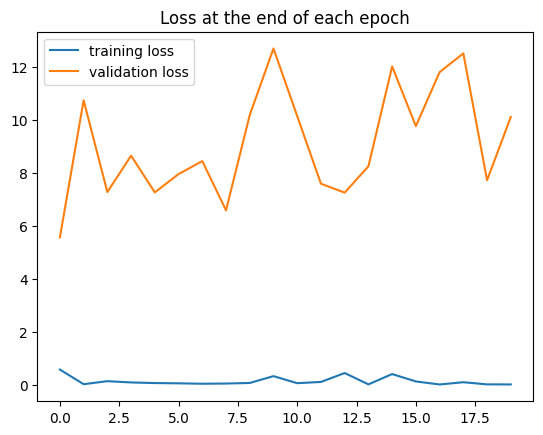

In [96]:
# Plotting loss graph.
train_losses = [t.cpu().detach().numpy() for t in train_losses]
test_losses = [t.cpu().detach().numpy() for t in test_losses]
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

In [11]:
#After training, load the best model that was saved.
model = AlexNet(num_classes).to(device)
model.load_state_dict(torch.load('hirise-alexnet-best.pt'))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [13]:
# Evaluate the best model. Code resused from the training loop.
from sklearn.metrics import f1_score
all_preds = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

#Weighted F1 due to the severe class imbalance.
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1-score on the test set: {f1:.4f}')

Weighted F1-score on the test set: 0.8899


In [19]:
#Calculating other metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Precision
precision = precision_score(all_labels, all_preds, average='weighted')

# Recall
recall = recall_score(all_labels, all_preds, average='weighted')

# Printing
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.8963
Precision: 0.8894
Recall: 0.8963


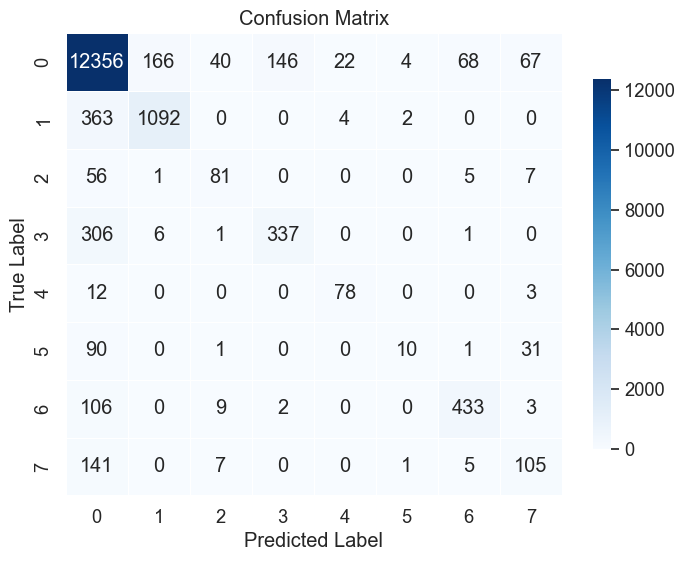

In [16]:
# Using predictions and true values to create a confusion matrix.
# Seaborn for plotting.
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(8), yticklabels=np.arange(8),
            linewidths=.5, cbar_kws={"shrink": 0.8})

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
len(all_preds)

16169